In [7]:
from fake_models import MessageSql
from fake_config import Settings
from sqlalchemy import create_engine, asc, or_
from sqlalchemy.orm import sessionmaker
import dotenv
import pendulum

house_alias = 'oak'

# Almost no wind (0-3 mph)
start_ms = pendulum.datetime(2025, 1, 13, 7, tz="America/New_York").timestamp() * 1000 
end_ms = pendulum.datetime(2025, 1, 13, 12, 5, tz="America/New_York").timestamp() * 1000 

# Some wind (5-10 mph)
start_ms = pendulum.datetime(2025, 1, 14, 7, tz="America/New_York").timestamp() * 1000 
end_ms = pendulum.datetime(2025, 1, 14, 12, 5, tz="America/New_York").timestamp() * 1000 

# Some more wind (10-15mph)
start_ms = pendulum.datetime(2025, 1, 15, 7, tz="America/New_York").timestamp() * 1000 
end_ms = pendulum.datetime(2025, 1, 15, 12, 5, tz="America/New_York").timestamp() * 1000 

# start_ms = pendulum.datetime(2025, 1, 5, 7, tz="America/New_York").timestamp() * 1000 
# end_ms = pendulum.datetime(2025, 1, 5, 12, 5, tz="America/New_York").timestamp() * 1000 

# start_ms = pendulum.datetime(2025, 1, 16, 7, tz="America/New_York").timestamp() * 1000 
# end_ms = pendulum.datetime(2025, 1, 16, 12, 5, tz="America/New_York").timestamp() * 1000 

import time
start_ms = pendulum.datetime(2025, 1, 20, 23, tz="America/New_York").timestamp() * 1000 
end_ms = pendulum.datetime(2025, 1, 21, 7, tz="America/New_York").timestamp() * 1000 

In [ ]:
# Actual energy used by the house
settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.visualizer_api_password.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%{house_alias}%'),
    or_(
        MessageSql.message_type_name == "batched.readings",
        MessageSql.message_type_name == "report"
        ),
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(asc(MessageSql.message_persisted_ms)).all()

channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        # Find the channel name
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        # Store the values and times for the channel
        if (('buffer-depth' in channel_name or ('tank' in channel_name and 'depth' in channel_name)) 
            and 'micro' not in channel_name):
            if channel_name not in channels:
                channels[channel_name] = {
                    'values': channel['ValueList'],
                    'times': channel['ScadaReadTimeUnixMsList']
                }
            else:
                channels[channel_name]['values'].extend(channel['ValueList'])
                channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time and find min/max
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['values'] = list(sorted_values)
    channels[key]['times'] = list(sorted_times)

KeyError: 'ChannelReadingList'

In [3]:
PRINT = False

# Find the energy used from the buffer during the on-peak period
first_values_buffer = []
last_values_buffer = []
for buffer_key in [x for x in channels if 'buffer' in x]:
    if PRINT: 
        print('')
        print(buffer_key)
    # Find the value closest to the start of on-peak
    differences = [abs(time - start_ms) for time in channels[buffer_key]['times'] if time < start_ms + 5*60*1000]
    closest_index = differences.index(min(differences))
    first_values_buffer.append(channels[buffer_key]['values'][closest_index])
    if PRINT: print(f"{first_values_buffer[-1]/1000} degC at {pendulum.from_timestamp(channels[buffer_key]['times'][closest_index]/1000, tz='America/New_York').replace(microsecond=0)}")
    # Find the value closest to the end of on-peak
    differences = [abs(time - end_ms) for time in channels[buffer_key]['times']]
    closest_index = differences.index(min(differences))
    last_values_buffer.append(channels[buffer_key]['values'][closest_index])
    if PRINT: print(f"{last_values_buffer[-1]/1000} degC at {pendulum.from_timestamp(channels[buffer_key]['times'][closest_index]/1000, tz='America/New_York').replace(microsecond=0)}")
if len(first_values_buffer) != 4 or len(last_values_buffer) != 4:
    print("Some buffer temperatures are missing")
else:
    first_values_buffer = [x/1000 for x in first_values_buffer]
    last_values_buffer = [x/1000 for x in last_values_buffer]
    buffer_avg_before = sum(first_values_buffer)/4
    buffer_avg_after = sum(last_values_buffer)/4
    buffer_energy_used = 120 * 3.785 * 4.187/3600 * (buffer_avg_before - buffer_avg_after)

# Find the energy used from the buffer during the on-peak period
first_values_store = []
last_values_store = []
for store_key in [x for x in channels if 'tank' in x]:
    if PRINT:
        print('')
        print(store_key)
    # Get the closest value to start on onpeak
    differences = [abs(time - start_ms) for time in channels[store_key]['times']]
    closest_index = differences.index(min(differences))
    first_values_store.append(channels[store_key]['values'][closest_index])
    if PRINT: print(f"{first_values_store[-1]/1000} degC at {pendulum.from_timestamp(channels[store_key]['times'][closest_index]/1000, tz='America/New_York').replace(microsecond=0)}")
    # Get the closest value to end of onpeak
    differences = [abs(time - end_ms) for time in channels[store_key]['times']]
    closest_index = differences.index(min(differences))
    last_values_store.append(channels[store_key]['values'][closest_index])
    if PRINT: print(f"{last_values_store[-1]/1000} degC at {pendulum.from_timestamp(channels[store_key]['times'][closest_index]/1000, tz='America/New_York').replace(microsecond=0)}")

if len(first_values_store) != 12 or len(last_values_store) != 12:
    print("Some storage temperatures are missing")
else:
    first_values_store = [x/1000 for x in first_values_store]
    last_values_store = [x/1000 for x in last_values_store]
    store_avg_before = sum(first_values_store)/12
    store_avg_after = sum(last_values_store)/12
    store_energy_used = 3 * 120 * 3.785 * 4.187/3600 * (store_avg_before - store_avg_after)

if PRINT: print('')
print(f"Energy from buffer: {round(buffer_energy_used,2)} kWh") 
print(f"Energy from storage: {round(store_energy_used,1)} kWh")
total_energy_used = store_energy_used+buffer_energy_used
print(f"Total energy used by house: {round(total_energy_used,1)} kWh")

Some buffer temperatures are missing
Some storage temperatures are missing


NameError: name 'buffer_energy_used' is not defined

In [ ]:
import requests
import datetime
import pytz
from datetime import datetime

def get_weather_data(latitude, longitude, start_time, end_time):    
    
    # Get the gridpoint info
    url = f"https://api.weather.gov/points/{latitude},{longitude}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching grid data: {response.status_code}")
        return []

    # Get the nearest observation station URL
    grid_data = response.json()
    station_url = grid_data['properties']['observationStations']
    station_response = requests.get(station_url)
    if station_response.status_code != 200:
        print(f"Error fetching station data: {station_response.status_code}")
        return []
    
    # Get the station ID (first station in the list)
    stations = station_response.json()
    station_id = stations['features'][0]['properties']['stationIdentifier']

    # Get hourly observations from the station
    observations_url = f"https://api.weather.gov/stations/{station_id}/observations"
    params = {
        'start': datetime.utcfromtimestamp(start_time).isoformat() + "Z",
        'end': datetime.utcfromtimestamp(end_time).isoformat() + "Z"
    }
    observations_response = requests.get(observations_url, params=params)
    if observations_response.status_code != 200:
        print(f"Error fetching observations data: {observations_response.status_code}")
        return []

    # Extract the relevant data (temperature, windSpeed)
    observations = observations_response.json()
    weather_data = {
        'time': [],
        'oat': [],
        'ws': []
    }
    # print(observations['features'][0]['properties']['temperature']['unitCode'])
    # print(observations['features'][0]['properties']['windSpeed']['unitCode'])
    for observation in observations['features']:
        weather_data['time'].append(datetime.fromisoformat(observation['properties']['timestamp']).astimezone(pytz.timezone('America/New_York')).strftime('%Y-%m-%d %H:%M:%S'))
        weather_data['oat'].append(observation['properties']['temperature']['value'])
        weather_data['ws'].append(observation['properties']['windSpeed']['value'])

    return weather_data

In [ ]:
KMLT_LAT, KMLT_LON = 45.6573, -68.7098
from datetime import timezone
import time

def to_fahrenheit(t):
    return (t * 9/5) + 32

def to_mph(ws):
    return ws * 0.621371

def test():
    # kmlt is the ICAO code for Millinocket
    url = f"https://api.weather.gov/points/{KMLT_LAT},{KMLT_LON}"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching grid data: {response.status_code}")
        return

    # Get the nearest observation station (this will be KMLT)
    grid_data = response.json()
    station_url = grid_data['properties']['observationStations']
    station_response = requests.get(station_url)
    if station_response.status_code != 200:
        print(f"Error fetching station data: {station_response.status_code}")
        return
    stations = station_response.json()
    station_id = stations['features'][0]['properties']['stationIdentifier']

    # Get hourly observations from the station
    observations_url = f"https://api.weather.gov/stations/{station_id}/observations"
    start_time = time.time() - 60*60
    end_time = time.time() + 5*60
    params = {
        'start': datetime.fromtimestamp(start_time, tz=timezone.utc).replace(tzinfo=None).isoformat() + "Z",
        'end': datetime.fromtimestamp(end_time, tz=timezone.utc).replace(tzinfo=None).isoformat() + "Z"
    }
    observations_response = requests.get(observations_url, params=params)
    if observations_response.status_code != 200:
        print(f"Error fetching observations data: {observations_response.status_code}")
        return
    observations = observations_response.json()
    if not observations:
        print("Received no observations")
        return
    # Take the latest observation
    time_observed = observations['features'][-1]['properties']['timestamp']
    time_observed = datetime.fromisoformat(time_observed).astimezone(pytz.timezone('America/New_York')).strftime('%Y-%m-%d %H:%M:%S')
    oat_observed = round(to_fahrenheit(observations['features'][-1]['properties']['temperature']['value']),2)
    wind_speed_observed = round(to_mph(observations['features'][-1]['properties']['windSpeed']['value']),2)
    print(f"\nTime of latest observation: {time_observed}")
    print(f"OAT: {oat_observed}, WS: {wind_speed_observed}")

test()

In [ ]:
# Get energy use forecast from weather and parameters
ALPHA = 6
BETA = -ALPHA/55
GAMMA = 0.25

def required_heating_power(oat, ws):
    r = ALPHA + BETA*oat + GAMMA*ws
    return r if r>0 else 0

def to_fahrenheit(t):
    return (t * 9/5) + 32

def to_mph(ws):
    return ws * 0.621371

data = get_weather_data(45.6573, -68.7098, start_ms/1000, end_ms/1000)
sorted_items = sorted(zip(data['time'], data['oat'], data['ws']), key=lambda x: datetime.strptime(x[0], '%Y-%m-%d %H:%M:%S'))
weather_data = {'time': [], 'oat': [], 'ws': []}
for time, oat, ws in sorted_items:
    weather_data['time'].append(time)
    weather_data['oat'].append(to_fahrenheit(oat))
    weather_data['ws'].append(to_mph(ws))
print(weather_data['oat'])
print(weather_data['ws'])

required_heat = 0
for i in range(5):
    required_heat += required_heating_power(weather_data['oat'][i], weather_data['ws'][i])

print(f"\nUsed: {round(total_energy_used,2)}")
print(f"Predicted: {round(required_heat,2)}")

In [ ]:
# When there is almost no wind (0-3mph), we are predicting way to high energy use
# When there is some wind (10-20) we are doing good
# Again when there is less wind (4-7) we are pedicting too high energy use

In [ ]:
import matplotlib.pyplot as plt

daily_dp = [50.13] * 7 + [487.63] * 5 + [54.98] * 4 + [487.63] * 4 + [50.13] * 4
plt.step(range(24), daily_dp)

daily_dp = [price + i*(1 if i<7 else 0) for price, i in zip(daily_dp, list(range(24)))]
daily_dp = [price + (i-11)*(1 if (i>11 and i<16) else 0) for price, i in zip(daily_dp, list(range(24)))]
daily_dp = [price + (i-19)*(1 if (i>19) else 0) for price, i in zip(daily_dp, list(range(24)))]
plt.step(range(24), daily_dp)

plt.show()

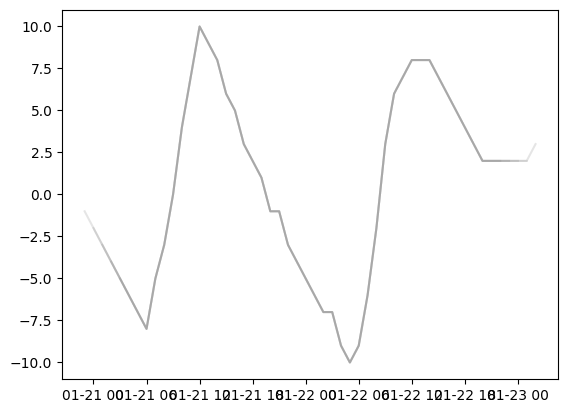

In [50]:
from datetime import datetime
import pytz

settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.visualizer_api_password.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)
session = Session()

weather_messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%{house_alias}%'),
    MessageSql.message_type_name == "weather.forecast",
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(asc(MessageSql.message_persisted_ms)).all()

oat_forecasts, ws_forecasts = {}, {}
for message in weather_messages:
    forecast_start_time = int((message.message_persisted_ms/1000 // 3600) * 3600)
    oat_forecasts[forecast_start_time] = message.payload['OatF']
    ws_forecasts[forecast_start_time] = message.payload['WindSpeedMph']

import matplotlib.pyplot as plt
for weather_time in oat_forecasts:
    forecast_times = [int(weather_time) + 3600*i for i in range(len(oat_forecasts[weather_time]))]
    forecast_times = [datetime.fromtimestamp(x, tz=pytz.timezone("America/New_York")) for x in forecast_times]
    plt.plot(forecast_times, oat_forecasts[weather_time], alpha=0.2, color='gray')
plt.show()